# Predicting Employee Reviews of Their Employers

The goal of this exercise is to implement a simple REST API to enter new input (a new employee review of a company) and and have a predicted class returned (1 to 5 stars). 

Before building a flask app and serving up a model that can accept input and return a prediction, I'm going to do some interactive work in this notebook (text pre-processing, model evaluation & selection, etc.). I'll then save the model so that it can be used in the flask app.

## Pre-processing the data & modeling

The first step here is to read in the data and get it into a format that's ready for a simple multi-class text classification model. As mentioned in the README, the csv is available [here](https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews). 

Given the goal of this exercise, I'm going to implement a relatively simple model and focus more on deploying it. Future work would involve additional feature engineering, modeling approaches, hyperparameter tuning, etc. 

Adhering to this simple approach, I'll limit my feature set to just the text/review fields in the data, dropping columns like the employee's location, date of review, and which company they're reviewing.  

In [1]:
import pandas as pd
import numpy as np
import src.utils as pp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
df = pd.read_csv("employee_reviews.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67529 entries, 0 to 67528
Data columns (total 17 columns):
Unnamed: 0                    67529 non-null int64
company                       67529 non-null object
location                      67529 non-null object
dates                         67529 non-null object
job-title                     67529 non-null object
summary                       67409 non-null object
pros                          67529 non-null object
cons                          67529 non-null object
advice-to-mgmt                67232 non-null object
overall-ratings               67529 non-null float64
work-balance-stars            67529 non-null object
culture-values-stars          67529 non-null object
carrer-opportunities-stars    67529 non-null object
comp-benefit-stars            67529 non-null object
senior-mangemnet-stars        67529 non-null object
helpful-count                 67529 non-null int64
link                          67529 non-null object
dtypes: 

In [3]:
df.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


In [4]:
#rename columns with hyphens; change them to underscores
df.columns = df.columns.str.replace('-', '_')

# select only columns of interest. Here that's the target (overall rating), and text fields:
# summary, pros, cons, advice-to-mgmt

cols = ['overall_ratings', 'summary', 'pros', 'cons', 'advice_to_mgmt']
text_cols = ['summary', 'pros', 'cons', 'advice_to_mgmt']

df = df[cols]

In [5]:
# %%timeit
# create one column of all text for the review, entering spaces between each
# performs much faster than .apply(lambda x: ' '.join(x), axis=1)
# fine for a handful of columns, but doesn't scale
df['review'] = df['summary'] + ' ' + df['pros'] + ' ' + df['cons'] + ' ' + df['advice_to_mgmt']

In [6]:
#quick visual inspection to make sure text columns aren't duplicates of each other
print([df[col].to_list()[7:8] for col in df[cols]])
print('--'*40)
print(df.review.to_list()[7:8])

[[5.0], ['great place to work and progress'], ['work culture, benefits, growth, people,'], ['No cons that i can think of'], ['none']]
--------------------------------------------------------------------------------
['great place to work and progress work culture, benefits, growth, people, No cons that i can think of none']


In [7]:
#drop the original text columns
df = df.drop(text_cols, axis=1)

#check null values
df.isnull().sum()

overall_ratings      0
review             407
dtype: int64

In [8]:
# since the dataset has 67k+ observations, 
# I'll just drop the 407 rows with no review / missing data
df = df.dropna(axis=0)

In [9]:
#read in contraction mapping
contraction_mapping = pp.contraction_mapping

#expand contractions in the review text
df['review'] = df['review'] \
    .apply(lambda x: pp.expand_contractions(x, contraction_mapping))

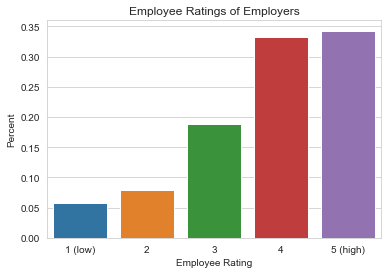

In [10]:
#check class balance of target variable
ratings = pd.DataFrame(
    df.overall_ratings.value_counts(normalize=True)
    ) \
    .reset_index() \
    .rename(columns={'index':'stars',
                     'overall_ratings':'pct'})

ax = sns.barplot(x='stars', y='pct', data=ratings)
ax.set(xlabel='Employee Rating', ylabel='Percent')
plt.title("Employee Ratings of Employers")
labels = ['1 (low)', '2', '3', '4', '5 (high)']
ax.set_xticklabels(labels)
plt.show();

So there is significant class imbalance in favor of 4-star and 5-star ratings. One way to account for this is to oversample the minority class and undersample the majority class (using Random Oversampling, the SMOTE algorithm, or something similar). 

## Feature Engineering & Modeling

Both CountVectorizer() and TfidfVectorizer() in scikit-learn will tokenize the text and remove stopwords, so doing those functions independently is unnecessary. In future iterations, I could vary the hyperparameters of the CountVectorizer / TfidfVectorizer, for example, including both unigrams and bigrams by altering the default ngram_range=(1,1) to (1,2). In the review examined above, a unigram approach has a representation of:
- \['great', 'place', 'to', 'work'\]

While bigrams would have the following representation:
- \['great place', 'place to', 'to work' \]


For features in this initial modeling approach, I'll use the tfidf (term frequency-inverse document frequency), specifying that only unigram representation of reviews be considered. In short, tfidf downweights frequently occurring words. 

For modeling, a simple way to approach this multiclass classification problem is to use the Multinomial Naive Bayes classifier. 

In [11]:
X = df.review.values
y = df.overall_ratings.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [12]:
#count_v = CountVectorizer()
#bow_train = count_v.fit_transform(X_train)
#bow_test = count_v.transform(X_test)

tfidf = TfidfVectorizer(stop_words='english')

tfidf_x_train = tfidf.fit_transform(X_train).toarray()
tfidf_x_test = tfidf.transform(X_test).toarray()

#### Oversampling

If doing k-fold cross validation, care should be taken as to when oversampling should be done. When oversampling before creating k-folds, you "contaminate" the training and testing folds (you're putting the same data in each).

Simple approach here, I won't do k-fold or stratified k-fold CV, so I'll oversample without that worry. 

In [13]:
#for a less naive algorithm, use SMOTE 
ros = RandomOverSampler(random_state=42)
X_sm, y_sm = ros.fit_resample(tfidf_x_train, y_train)

In [14]:
nb_clf = MultinomialNB()

nb_model = nb_clf.fit(X_sm, y_sm)

#### Save Model

Since I'm not as focused on model complexity and model accuracy during this MVP / first pass, I'll just go ahead and save the fitted model and tfidf vectorizer as pickle files so that they can be loaded and used in a webapp. 

In [15]:
joblib.dump(tfidf, "models/tfidf_vec.pkl")
joblib.dump(nb_model, "models/nb_model.pkl")

['project/models/nb_model.pkl']

#### Evaluate Model

In [16]:
rev1 = ["This company is awful! I'm never working here again."]

print("Class Prediction:", 
      nb_clf.predict(
          tfidf.transform(rev1)
      ),'\n',
      'Class Probabilities:',
      nb_clf.predict_proba(
          tfidf.transform(rev1)
      )
     )

Class Prediction: [1.] 
 Class Probabilities: [[0.46624633 0.25228919 0.1485785  0.07047331 0.06241268]]


In [17]:
rev2 = ["All my coworkers keep microwaving fish. They should be fired."]

print("Class Prediction:", 
      nb_clf.predict(
          tfidf.transform(rev2)
      ),'\n',
      'Class Probabilities:',
      nb_clf.predict_proba(
          tfidf.transform(rev2)
      )
     )

Class Prediction: [3.] 
 Class Probabilities: [[0.22948536 0.17144381 0.28934599 0.14668873 0.16303611]]


So those two examples look okay. What are the model metrics?

In [18]:
y_pred_train = nb_clf.predict(X_sm)

In [19]:
print(classification_report(y_sm, y_pred_train))

              precision    recall  f1-score   support

         1.0       0.72      0.84      0.78     17296
         2.0       0.71      0.73      0.72     17296
         3.0       0.64      0.55      0.59     17296
         4.0       0.55      0.55      0.55     17296
         5.0       0.69      0.65      0.67     17296

   micro avg       0.66      0.66      0.66     86480
   macro avg       0.66      0.66      0.66     86480
weighted avg       0.66      0.66      0.66     86480



In [20]:
accuracy_score(y_sm, y_pred_train)

0.6639569842738205

So the model isn't that great, with all metrics hovering around 66 percent. Let's check the performance on the test set to see how well the model generalizes to new data.  

In [21]:
y_pred_test = nb_clf.predict(tfidf_x_test)

In [22]:
accuracy_score(y_test, y_pred_test)

0.43221500506525234

In [23]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         1.0       0.29      0.57      0.39      1004
         2.0       0.20      0.34      0.25      1340
         3.0       0.31      0.27      0.29      3107
         4.0       0.46      0.40      0.43      5613
         5.0       0.63      0.55      0.58      5717

   micro avg       0.43      0.43      0.43     16781
   macro avg       0.38      0.43      0.39     16781
weighted avg       0.46      0.43      0.44     16781



### Yikes!

So I've dramatically overfit the data. While I'm still doing better than a random classifier (1/5 = 20%), 43 perent accuracy is not great. But I have a working model and I've exported it for use in a webapp.

I'll turn to building that app next, and once that's up and running, I'll come back and test different models, and integrate multiple models into the app. 